In [622]:
import cdlib
import pandas as pd
import networkx as nx
from cdlib import algorithms
from collections import Counter
import plotly.express as px
from cdlib import evaluation
from cdlib import viz
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Graph object creation

In [623]:
nodeList = pd.read_csv('data/bd-node.csv', index_col = 'id')
edgeList = pd.read_csv('data/bd-edge.csv')

In [624]:
len(nodeList)

11775

In [625]:
nodeList

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020
...,...,...,...,...,...,...
20494,La notte delle ricostruzioni,Donaera Andrea,Tetra,Letteratura italiana: testi,1.0,2022
20495,L'ultimo raccolto,Zardi Paolo,Tetra,Letteratura italiana: testi,1.0,2022
20496,X. Una caccia,Aiolli Valerio,Tetra,Letteratura italiana: testi,1.0,2022


In [626]:
g = nx.from_pandas_edgelist(edgeList, 'Source', 'Target', ['Weight'])

In [627]:
#create a nested dict in which we can append all the info for each node of the nodelist
InfoNdic = {}

for index, row in nodeList.iterrows():
    InfoNdic[index] = {'BookName': row['titolo'], 'BookAuthor': row['autore'], 'BookPublisher': row['editore'],'BookGenre': row['categoria'], 'RecommendationsReceived' : row['raccomandazioni-ricevute'], 'YearOfPublication': row['anno-pubblicazione'] }


In [628]:
InfoNdic[11818]

{'BookName': 'Hokusai. Pop-up',
 'BookAuthor': 'McCarthy Courtney Watson',
 'BookPublisher': 'White Star',
 'BookGenre': 'Disegno, arti decorative e minori',
 'RecommendationsReceived': 1.0,
 'YearOfPublication': 2016}

In [629]:
len(InfoNdic)

11775

In [630]:
len(nx.nodes(g))


11775

In [631]:
#setting the attributes of each node using the info contained in the nested dict
nx.set_node_attributes(g, InfoNdic)

In [632]:
#get nodes attributes:

name = nx.get_node_attributes(g, "BookName")
author = nx.get_node_attributes(g, "BookAuthor")
publisher = nx.get_node_attributes(g, "BookPublisher")
genre = nx.get_node_attributes(g, "BookGenre")
recommendations = nx.get_node_attributes(g, "RecommendationsReceived")
year = nx.get_node_attributes(g, "YearOfPublication")

In [633]:
genre[11818]

'Disegno, arti decorative e minori'

In [634]:
name[0]

"Cambiare l'acqua ai fiori"

In [635]:
#select the giant component and continue working with that.
compsList = list(nx.connected_components(g))
GC = g.subgraph(compsList[0])
g = GC

In [636]:
len(g)

11573

# Community Discovery algorithms

## Approach 1: Internal Density
Communities as sets of densely connected entities
Each community must have a number of edges significantly higher than what expected in a random graph

### Louvain

It works finding a function of density and maxime it.


In [637]:
louv_coms = algorithms.louvain(g, weight='weight', resolution=1.)

In [638]:
#function to retrieve the info of the communities found out by the algorithm
def InfoCommunity(communitiesList, algorithm):
    print(f"This algorithm has discovered {len(communitiesList)} communities.")
    print()
    C = [g.subgraph(c).copy() for c in communitiesList]
    sumNodes = 0
    sumEdges = 0
    for count, comm in enumerate(C):
        print(f"Community: {count} - Info: {nx.number_of_nodes(comm)} nodes & {nx.number_of_edges(comm)} edges")
        sumNodes += nx.number_of_nodes(comm)
        sumEdges += nx.number_of_edges(comm)
    print()
    print(f"These communities have a total of {sumNodes} nodes and {sumEdges} edges.")
    print()
    print("Communities statistics: ")
    print("Nodes: " , evaluation.size(g, algorithm))
    print("Edges: ", evaluation.edges_inside(g,algorithm))

In [639]:
InfoCommunity(louv_coms.communities, louv_coms)

This algorithm has discovered 27 communities.

Community: 0 - Info: 1793 nodes & 88551 edges
Community: 1 - Info: 1792 nodes & 153183 edges
Community: 2 - Info: 1503 nodes & 86063 edges
Community: 3 - Info: 859 nodes & 36711 edges
Community: 4 - Info: 606 nodes & 48151 edges
Community: 5 - Info: 587 nodes & 31107 edges
Community: 6 - Info: 586 nodes & 22845 edges
Community: 7 - Info: 515 nodes & 64651 edges
Community: 8 - Info: 512 nodes & 26715 edges
Community: 9 - Info: 446 nodes & 26652 edges
Community: 10 - Info: 366 nodes & 25589 edges
Community: 11 - Info: 326 nodes & 41323 edges
Community: 12 - Info: 253 nodes & 8785 edges
Community: 13 - Info: 252 nodes & 11689 edges
Community: 14 - Info: 246 nodes & 9245 edges
Community: 15 - Info: 222 nodes & 6040 edges
Community: 16 - Info: 183 nodes & 6592 edges
Community: 17 - Info: 172 nodes & 11017 edges
Community: 18 - Info: 87 nodes & 3741 edges
Community: 19 - Info: 84 nodes & 3486 edges
Community: 20 - Info: 39 nodes & 605 edges
Comm

In [640]:
louv_coms.communities

[[20,
  31,
  32,
  41,
  56,
  59,
  60,
  70,
  79,
  97,
  145,
  146,
  171,
  172,
  184,
  186,
  218,
  221,
  229,
  230,
  235,
  240,
  258,
  261,
  280,
  282,
  285,
  301,
  306,
  327,
  345,
  360,
  362,
  390,
  396,
  410,
  411,
  435,
  437,
  450,
  475,
  481,
  484,
  491,
  496,
  498,
  506,
  512,
  517,
  518,
  531,
  532,
  533,
  536,
  586,
  602,
  606,
  608,
  617,
  618,
  619,
  627,
  635,
  651,
  665,
  695,
  696,
  697,
  698,
  707,
  710,
  711,
  730,
  731,
  738,
  739,
  741,
  746,
  768,
  779,
  780,
  863,
  867,
  869,
  893,
  907,
  911,
  918,
  966,
  973,
  990,
  998,
  999,
  1010,
  1015,
  1022,
  1028,
  1038,
  1040,
  1042,
  1049,
  1060,
  1064,
  1069,
  1070,
  1072,
  1075,
  1078,
  1090,
  1109,
  1125,
  1129,
  1148,
  1156,
  1181,
  1200,
  1204,
  1231,
  1235,
  1269,
  1296,
  1303,
  1373,
  1384,
  1391,
  1464,
  1475,
  1479,
  1495,
  1577,
  1634,
  1650,
  1654,
  1676,
  1703,
  1723,
  1727,
  1731,

In [641]:
#no overlapping
louv_coms.overlap

False

In [642]:
#nodes composing community 1
louv_coms.communities[0]

[20,
 31,
 32,
 41,
 56,
 59,
 60,
 70,
 79,
 97,
 145,
 146,
 171,
 172,
 184,
 186,
 218,
 221,
 229,
 230,
 235,
 240,
 258,
 261,
 280,
 282,
 285,
 301,
 306,
 327,
 345,
 360,
 362,
 390,
 396,
 410,
 411,
 435,
 437,
 450,
 475,
 481,
 484,
 491,
 496,
 498,
 506,
 512,
 517,
 518,
 531,
 532,
 533,
 536,
 586,
 602,
 606,
 608,
 617,
 618,
 619,
 627,
 635,
 651,
 665,
 695,
 696,
 697,
 698,
 707,
 710,
 711,
 730,
 731,
 738,
 739,
 741,
 746,
 768,
 779,
 780,
 863,
 867,
 869,
 893,
 907,
 911,
 918,
 966,
 973,
 990,
 998,
 999,
 1010,
 1015,
 1022,
 1028,
 1038,
 1040,
 1042,
 1049,
 1060,
 1064,
 1069,
 1070,
 1072,
 1075,
 1078,
 1090,
 1109,
 1125,
 1129,
 1148,
 1156,
 1181,
 1200,
 1204,
 1231,
 1235,
 1269,
 1296,
 1303,
 1373,
 1384,
 1391,
 1464,
 1475,
 1479,
 1495,
 1577,
 1634,
 1650,
 1654,
 1676,
 1703,
 1723,
 1727,
 1731,
 1737,
 1738,
 1742,
 1746,
 1747,
 1758,
 1772,
 1804,
 1806,
 1815,
 1877,
 1890,
 1906,
 1911,
 1913,
 1952,
 1959,
 1988,
 2020,
 204

#### Internal Evaluation : Fitness scores

##### Partitions quality functions
Using some fitness functions that can be defined to assess the quality of a partition

In [646]:
def FitnessFunctions(CommunityType):

    print("INTERNAL EVALUATION")
    print()
    #average internal degree (AID) = the average internal degree of the community set.
    print(f"1 - Average Internal Degree: \n{evaluation.average_internal_degree(g, CommunityType)}")
    print()
    print()
    #internal edge density (IED) = The internal density of the community set.
    print(f"2 - Internal Edge Density: \n{evaluation.internal_edge_density(g,CommunityType)}")
    print()
    print()
    #conductance (C) = Fraction of total edge volume that points outside the community.
    print(f"3 - Conductance : \n{evaluation.conductance(g,CommunityType)}")
    print()
    print()
    # Triangle participation ratio (TPR) = Fraction of community nodes that belong to a triad.
    print(f"4 - Triangle Participation Ratio : \n{evaluation.triangle_participation_ratio(g,CommunityType)}")
    print()
    print()
    # #Girvan-Newmann modularity (GNM)
    print(f"5 - Newmann modularity : \n{evaluation.newman_girvan_modularity(g,CommunityType)}")
    print()
    print()
    #Expansion = Number of edges per community node that point outside the cluster.
    print(f"6 - Expansion : \n{evaluation.expansion(g,CommunityType)}")
    print()
    print()
    #Normalized-cut (NC)= normalized variant of cut-ratio, that is the fraction of existing edges (out of all possible edges) leaving the community.
    print(f"7 - Normalized cut : \n{evaluation.normalized_cut(g,CommunityType)}")
    print()
    print()
    #Average ODF Degree (AODFD): the average fraction of edges of a node of a community that point outside the community itself.
    print(f"8 - Average ODF Degree : \n{evaluation.avg_odf(g,CommunityType)}")
    print()
    print()
    #Flake ODF = Fraction of nodes in S that have fewer edges pointing inside than to the outside of the community.
    print(f"9 - Flake ODF : \n{evaluation.flake_odf(g,CommunityType)}")
    print()
    print()
    # Fraction over median degree = Fraction of community nodes of having internal degree higher than the median degree value.
    print(f"10 - Fraction over median degree : \n{evaluation.fraction_over_median_degree(g,CommunityType)}")
    print()
    print()
    # Node_coverage = Fraction of total edge volume that points outside the community.
    print(f"11 - Node coverage : \n{louv_coms.node_coverage}")




In [647]:
FitnessFunctions(louv_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=10.0, max=253.51533742331287, score=92.99477852332299, std=61.801007239838164)


2 - Internal Edge Density: 
FitnessResult(min=0.055119487491036574, max=1.0, score=0.5254557865004453, std=0.3627086577996059)


3 - Conductance : 
FitnessResult(min=0.09090909090909091, max=0.40149496387651634, score=0.2452442348635856, std=0.09405861111142742)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.994535519125683, max=1.0, score=0.9992464850759778, std=0.0015023273221129378)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.623536313719432, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=107.84466019417475, score=33.3633493901351, std=24.24475336625037)


7 - Normalized cut : 
FitnessResult(min=0.09091465944947016, max=0.4228427572047107, score=0.25596516699652594, std=0.09979134452126628)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=107.84466019417475, score=33.3633493901351, st

#### Semantic Analysis of the single communities [Louvain]

##### Community 1

In [648]:
#using the nodelist as a DF of attributes
AttrDF1 = nodeList
AttrDF1

,titolo,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,,
0,Cambiare l'acqua ai fiori,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,"Ragazza, donna, altro",Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,L'Ickabog,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Dante,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Borgo Sud,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020
...,...,...,...,...,...,...
20494,La notte delle ricostruzioni,Donaera Andrea,Tetra,Letteratura italiana: testi,1.0,2022
20495,L'ultimo raccolto,Zardi Paolo,Tetra,Letteratura italiana: testi,1.0,2022
20496,X. Una caccia,Aiolli Valerio,Tetra,Letteratura italiana: testi,1.0,2022


In [649]:
AttrDF1 = AttrDF1.drop(['titolo'], axis =1)
AttrDF1

,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,
0,Perrin Valérie,E/O,Letterature straniere: testi,64.0,2019
1,Evaristo Bernardine,Sur,Letterature straniere: testi,61.0,2020
2,Rowling J. K.,Salani,Letteratura per ragazzi,44.0,2020
3,Barbero Alessandro,Laterza,Letteratura italiana: critica,37.0,2020
4,Di Pietrantonio Donatella,Einaudi,Letteratura italiana: testi,36.0,2020
...,...,...,...,...,...
20494,Donaera Andrea,Tetra,Letteratura italiana: testi,1.0,2022
20495,Zardi Paolo,Tetra,Letteratura italiana: testi,1.0,2022
20496,Aiolli Valerio,Tetra,Letteratura italiana: testi,1.0,2022


In [650]:
AttrDF_comm1 = AttrDF1[AttrDF1.index.isin(louv_coms.communities[0])]

In [651]:
AttrDF_comm1.dtypes

autore                       object
editore                      object
categoria                    object
raccomandazioni-ricevute    float64
anno-pubblicazione            int64
dtype: object

In [652]:
AttrDF_comm1['autore'] = AttrDF_comm1['autore'].astype('category')
AttrDF_comm1['editore'] = AttrDF_comm1['categoria'].astype('category')
AttrDF_comm1['categoria'] =AttrDF_comm1['categoria'].astype('category')

In [653]:
#transform categorical values into scalar values
cat_columns = AttrDF_comm1.select_dtypes(['category']).columns
AttrDF_comm1[cat_columns] = AttrDF_comm1[cat_columns].apply(lambda x: x.cat.codes)
AttrDF_comm1

,autore,editore,categoria,raccomandazioni-ricevute,anno-pubblicazione
id,,,,,
20,15,19,19,23.0,2019
31,1162,19,19,19.0,2020
32,256,19,19,19.0,2020
41,493,19,19,18.0,2016
56,483,19,19,16.0,2018
...,...,...,...,...,...
20276,191,19,19,1.0,2021
20296,428,18,18,1.0,2021
20312,734,19,19,1.0,2022


In [654]:
#Frequency analysis of attributes of comm.1 attributes

authors_coms1 = []
genres_coms1 = []
years_coms1 = []
publishers_coms1 = []
bookdealers_coms1 = []

cntAuthor= Counter()
cntGenre = Counter()
cntYear = Counter()
cntPub = Counter()
cntBookdealer = Counter()


In [655]:
#function to add each information of the single node of the community to each list
def addToList(AuthorList, GenreList, YearList, PublisherList, BookdealerList, community):
    for node in community:
        AuthorList.append(author[node])
        GenreList.append(genre[node])
        YearList.append(year[node])
        PublisherList.append(publisher[node])
        BookdealerList.append(recommendations[node])

#function to count frequency of the info of the nodes composing the community and find the most common
def mostCommon(counter, list):
    for el in list:
        counter[el] += 1

    return(counter.most_common())


In [656]:

addToList(authors_coms1, genres_coms1, years_coms1,publishers_coms1, bookdealers_coms1, louv_coms.communities[0])

In [657]:
#most common Genres
for el in (mostCommon(cntGenre, genres_coms1)):
    print(el)

('Letteratura per ragazzi', 1499)
('Letterature straniere: testi', 68)
('Letteratura italiana: testi', 54)
('Disegno, arti decorative e minori', 47)
('Educazione', 16)
('Psicologia', 13)
('Arti ricreative. spettacolo. sport', 10)
('Scienze sociali', 10)
('Musica', 10)
('Geografia generale. viaggi', 8)
('Economia domestica e vita familiare', 8)
("Storia d'europa", 5)
('Letteratura', 5)
('Scienze botaniche', 4)
('Pittura', 4)
('Scienze zoologiche', 3)
('Agricoltura e tecnologie connesse', 3)
('Problemi e servizi sociali', 3)
('Letterature straniere: critica', 2)
('Altre religioni. religione comparata', 2)
('Geografia e storia', 2)
('Letteratura italiana: critica', 2)
('Altro', 2)
('Urbanistica e arte del paesaggio', 2)
('Architettura', 2)
('Fotografia', 1)
('Fenomeni e tecniche paranormali', 1)
('Teologia sociale ed ecclesiastica', 1)
('Chimica e scienze connesse', 1)
('Filosofia e discipline connesse', 1)
('Scienze della vita', 1)
('Astronomia e scienze connesse', 1)
('Biblioteconomia. 

In [658]:
#distribution per frequency
GenreFreq = pd.DataFrame(columns=['Genre', 'Frequency'])
for count, el in enumerate(cntGenre.most_common()):
    new_row = {'Genre': el[0], 'Frequency': el[1]}
    GenreFreq = GenreFreq.append(new_row, ignore_index=True)

fig1 = px.bar(GenreFreq, x="Genre", y="Frequency", title = 'Frequency distribution of genre in comm. 1')
fig1.update_layout(bargap=0.3)
fig1.show()

In [659]:
#distribution per frequency of genres in nodelist

GenresNodelist = []
for index, row in nodeList.iterrows():
    GenresNodelist.append(nodeList.loc[index, 'categoria'])

cntGenresNodelist = Counter()

mostCommon(cntGenresNodelist, GenresNodelist)

GenreFreqNodelist = pd.DataFrame(columns=['Genre', 'Frequency'])
for count, el in enumerate(cntGenresNodelist.most_common()):
    new_row = {'Genre': el[0], 'Frequency': el[1]}
    GenreFreqNodelist = GenreFreqNodelist.append(new_row, ignore_index=True)

fig1_1 = px.bar(GenreFreqNodelist, x="Genre", y="Frequency", title = 'Frequency distribution of genre in our network')
fig1_1.update_layout(bargap=0.3)
fig1_1.show()

In [660]:
#merging and joining the dataframe with the genres+frequency of community 1 and those relative to the entire network
GenreFreqComparison = pd.merge(left=GenreFreq, right=GenreFreqNodelist, how='outer', on='Genre')
GenreFreqComparison.rename(columns={'Frequency_x':'community1_frequency','Frequency_y':'network_frequency'}, inplace=True)
GenreFreqComparison

,Genre,community1_frequency,network_frequency
0,Letteratura per ragazzi,1499,3196
1,Letterature straniere: testi,68,2760
2,Letteratura italiana: testi,54,2129
3,"Disegno, arti decorative e minori",47,549
4,Educazione,16,63
...,...,...,...
76,Logica,NaN,1
77,Paleontologia. paleozoologia,NaN,1
78,Linguaggio,NaN,1
79,Specifiche posizioni filosofiche,NaN,1


In [661]:
#replace NaN values with 0
GenreFreqComparison['community1_frequency'] = GenreFreqComparison['community1_frequency'].fillna(0)
GenreFreqComparison

,Genre,community1_frequency,network_frequency
0,Letteratura per ragazzi,1499,3196
1,Letterature straniere: testi,68,2760
2,Letteratura italiana: testi,54,2129
3,"Disegno, arti decorative e minori",47,549
4,Educazione,16,63
...,...,...,...
76,Logica,0,1
77,Paleontologia. paleozoologia,0,1
78,Linguaggio,0,1
79,Specifiche posizioni filosofiche,0,1


In [665]:
#most common Publishers
for el in (mostCommon(cntPub, publishers_coms1)):
    print(el)

('Babalibri', 100)
('Terre di Mezzo', 79)
('Orecchio Acerbo', 75)
('Mondadori', 69)
('Lapis', 64)
("L'Ippocampo Ragazzi", 62)
('Il Castoro', 61)
('Salani', 49)
('Einaudi Ragazzi', 41)
('Emme Edizioni', 40)
('Rizzoli', 39)
('Gallucci', 39)
('TopiPittori', 37)
('Camelozampa', 37)
('Editoriale Scienza', 32)
('Sinnos', 30)
('Logos', 28)
('Piemme', 24)
('Tunué', 24)
('Sassi', 24)
("L'Ippocampo", 23)
('Franco Cosimo Panini', 22)
('La Margherita', 22)
('EL', 21)
('Fatatrac', 20)
('Pelledoca Editore', 19)
('La Nuova Frontiera Junior', 18)
('Zoolibri', 18)
('Settenove', 18)
('Giunti Editore', 15)
('Iperborea', 15)
('Feltrinelli', 14)
('Gribaudo', 14)
('Nord-Sud', 14)
('Beisler', 14)
('minibombo', 13)
('LupoGuido', 13)
('Pulce', 13)
('EDT-Giralangolo', 13)
('BUR Biblioteca Univ. Rizzoli', 12)
('Edizioni Clichy', 12)
('IdeeAli', 12)
('Donzelli', 12)
('De Agostini', 11)
('Fabbri', 11)
('Kite', 10)
('Uovonero', 10)
('Bompiani', 10)
('Carthusia', 10)
('Bohem Press Italia', 10)
('Corraini', 10)
('Har

In [666]:
#distribution per frequency
PublisherFreq = pd.DataFrame(columns=['Publisher', 'Frequency'])
for count, el in enumerate(cntPub.most_common()):
    new_row = {'Publisher': el[0], 'Frequency': el[1]}
    PublisherFreq = PublisherFreq.append(new_row, ignore_index=True)

fig11 = px.bar(PublisherFreq, x="Publisher", y="Frequency", title = 'Frequency distribution of publishers in comm. 1')
fig11.update_layout(bargap=0.3)
fig11.show()

In [667]:
#distribution per frequency of publishers in nodelist

PublishersNodelist = []
for index, row in nodeList.iterrows():
    PublishersNodelist.append(nodeList.loc[index, 'editore'])

cntPubNodelist = Counter()

mostCommon(cntPubNodelist, PublishersNodelist)

PubFreqNodelist = pd.DataFrame(columns=['Genre', 'Frequency'])
for count, el in enumerate(cntPubNodelist.most_common()):
    new_row = {'Publisher': el[0], 'Frequency': el[1]}
    PubFreqNodelist = PubFreqNodelist.append(new_row, ignore_index=True)

fig12 = px.bar(PubFreqNodelist, x="Publisher", y="Frequency", title = 'Frequency distribution of publishers in our network')
fig12.update_layout(bargap=0.3)
fig12.show()

In [668]:
#merging and joining the dataframe with the publisher+frequency of community 1 and those relative to the entire network
PublFreqComparison = pd.merge(left=PublisherFreq, right=PubFreqNodelist, how='outer', on='Publisher')
PublFreqComparison.rename(columns={'Frequency_x':'community1_frequency','Frequency_y':'network_frequency'}, inplace=True)

del PublFreqComparison['Genre']
PublFreqComparison

,Publisher,community1_frequency,network_frequency
0,Babalibri,100,149
1,Terre di Mezzo,79,140
2,Orecchio Acerbo,75,119
3,Mondadori,69,506
4,Lapis,64,91
...,...,...,...
1005,Ubiliber,NaN,1
1006,Capovolte,NaN,1
1007,Kriss,NaN,1
1008,Edizioni Malamente,NaN,1


In [669]:
#replace NaN values with 0
PublFreqComparison['community1_frequency'] = PublFreqComparison['community1_frequency'].fillna(0)
PublFreqComparison

,Publisher,community1_frequency,network_frequency
0,Babalibri,100,149
1,Terre di Mezzo,79,140
2,Orecchio Acerbo,75,119
3,Mondadori,69,506
4,Lapis,64,91
...,...,...,...
1005,Ubiliber,0,1
1006,Capovolte,0,1
1007,Kriss,0,1
1008,Edizioni Malamente,0,1


##### Assortative mixing with node attributes on community 1

In [676]:
#transform each community into its relative graph
C = [g.subgraph(c).copy() for c in louv_coms.communities]

#comm 1 graph
G_comm1 = C[0]


In [677]:
#Newman's assortativity: Degree assortative = if Nodes tends to connect homogeneously w.r.t. their degree (e.g., hubs with hubs)
nx.degree_assortativity_coefficient(G_comm1)

0.08610461815411075

In [678]:
#function to retrieve the assortative mixing wth all the nodes attributes of comm.1 and those of the whole network
# +  adding these values into a DF
def AssortativeMixing(communitySet, GraphCommunitySet):
    df = pd.DataFrame(columns=["Network"])
    df.loc["Genre"] = nx.attribute_assortativity_coefficient(g, 'BookGenre')
    df.loc["Publisher"] = nx.attribute_assortativity_coefficient(g, 'BookPublisher')
    df.loc["Author"] = nx.attribute_assortativity_coefficient(g, 'BookAuthor')
    df.loc["Year"] = nx.attribute_assortativity_coefficient(g, 'YearOfPublication')
    df.loc["Recommendations"] = nx.attribute_assortativity_coefficient(g, 'RecommendationsReceived')
    for x in range(len(communitySet)):
        n_of_comm = x+1
        assGenre = nx.attribute_assortativity_coefficient(GraphCommunitySet[x], 'BookGenre')
        assPubl = nx.attribute_assortativity_coefficient(GraphCommunitySet[x], 'BookPublisher')
        assAuth = nx.attribute_assortativity_coefficient(GraphCommunitySet[x], 'BookAuthor')
        assYear = nx.attribute_assortativity_coefficient(GraphCommunitySet[x], 'YearOfPublication')
        assRecomm = nx.attribute_assortativity_coefficient(GraphCommunitySet[x], 'RecommendationsReceived')
        df.insert(x+1, f"Comm. {x+1}",[assGenre, assPubl, assAuth, assYear, assRecomm], True)
        #print(f"Assortativity community {n_of_comm}:")
        #print(f"Genre: {assGenre} - Publisher: {assPubl} - Author: {assAuth} - Year: {assYear} - Recommendations: {assRecomm}")
        #print()
        #print()
    return df

In [679]:
AssortativeMixingDF = AssortativeMixing(louv_coms.communities, C)
AssortativeMixingDF

,Network,Comm. 1,Comm. 2,Comm. 3,Comm. 4,Comm. 5,Comm. 6,Comm. 7,Comm. 8,Comm. 9,...,Comm. 18,Comm. 19,Comm. 20,Comm. 21,Comm. 22,Comm. 23,Comm. 24,Comm. 25,Comm. 26,Comm. 27
Genre,0.216410,0.089608,0.017899,0.030115,0.048206,0.043337,0.083592,0.018213,0.003672,0.052429,...,0.001217,-0.011628,-0.012048,-0.024195,-0.027778,-0.030303,-0.037037,-0.0625,-0.0625,-0.1
Publisher,0.046855,0.029726,0.021219,0.037963,0.011579,0.002696,0.009638,0.014185,0.001071,0.015147,...,-0.005151,-0.011628,-0.012048,-0.028666,-0.027778,-0.030303,-0.037037,-0.0625,-0.0625,-0.1
Author,0.004049,0.003434,0.000848,0.004342,0.002143,-0.002147,-0.000684,0.000410,-0.002300,0.000370,...,-0.006338,-0.011628,-0.012048,-0.028527,-0.027778,-0.030303,-0.037037,-0.0625,-0.0625,-0.1
Year,0.090426,0.028502,0.056445,0.043281,0.012806,0.042221,0.109651,0.076827,0.001088,0.014802,...,0.005585,-0.011628,-0.012048,-0.024504,-0.027778,-0.030303,-0.037037,-0.0625,-0.0625,-0.1
Recommendations,0.031507,0.005834,0.006478,0.010835,-0.000927,-0.001032,0.025679,0.010897,-0.003735,0.014030,...,-0.006005,-0.011628,-0.012048,-0.031567,-0.027778,-0.030303,-0.037037,-0.0625,NaN,-0.1


In [691]:
#Assortative mixing of 'Book Genre' attribute on the entire network
tmp = nx.attribute_mixing_dict(g, attribute= 'BookGenre', normalized= True)

In [693]:
tmp['Letteratura per ragazzi']['Letterature']

2.6322689854931605e-05

##### Community 2

##### Community 3


## Approach 2: Percolation
Communities as a set of nodes grouped together by the propagation of a same property/action/information

### Label Propagation

In [47]:
lp_coms = algorithms.label_propagation(g)

In [48]:
lp_coms.method_name

'Label Propagation'

In [49]:
InfoCommunity(lp_coms.communities, lp_coms)

This algorithm has discovered 108 communities.

Community: 0 - Info: 9353 nodes & 910191 edges
Community: 1 - Info: 150 nodes & 6757 edges
Community: 2 - Info: 121 nodes & 3949 edges
Community: 3 - Info: 99 nodes & 4851 edges
Community: 4 - Info: 89 nodes & 3916 edges
Community: 5 - Info: 80 nodes & 3160 edges
Community: 6 - Info: 79 nodes & 3081 edges
Community: 7 - Info: 73 nodes & 1336 edges
Community: 8 - Info: 72 nodes & 1404 edges
Community: 9 - Info: 71 nodes & 2485 edges
Community: 10 - Info: 62 nodes & 967 edges
Community: 11 - Info: 58 nodes & 1653 edges
Community: 12 - Info: 51 nodes & 1275 edges
Community: 13 - Info: 47 nodes & 993 edges
Community: 14 - Info: 44 nodes & 864 edges
Community: 15 - Info: 43 nodes & 903 edges
Community: 16 - Info: 36 nodes & 506 edges
Community: 17 - Info: 36 nodes & 630 edges
Community: 18 - Info: 35 nodes & 307 edges
Community: 19 - Info: 33 nodes & 528 edges
Community: 20 - Info: 29 nodes & 238 edges
Community: 21 - Info: 29 nodes & 406 edge

In [50]:
lp_coms.communities


[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [51]:
lp_coms.communities[0]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [52]:
lp_coms.size()

FitnessResult(min=2, max=9353, score=107.1574074074074, std=894.1987222382605)

In [53]:
lp_coms.overlap

False

In [54]:
FitnessFunctions(lp_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=1.0, max=194.6308136426815, score=18.8442581410357, std=26.39105196437351)


2 - Internal Edge Density: 
FitnessResult(min=0.020811678105504865, max=1.0, score=0.9481069277673193, std=0.15455223715201294)


3 - Conductance : 
FitnessResult(min=0.016835587835947532, max=0.5714285714285714, score=0.344580279492796, std=0.1319559418923727)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.0, max=1.0, score=0.9629599930305587, std=0.18885199462371216)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.08889187188396865, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.269557333306938)


7 - Normalized cut : 
FitnessResult(min=0.05211556500816209, max=0.571436670701358, score=0.34628393276137215, std=0.12901344898105024)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=47.44444444444444, score=7.9959156306567865, std=8.26955733330693

#### Semantic Analysis of the single communities [Label Propagation]

##### Community 1

In [55]:
authors_lp_coms1 = []
genres_lp_coms1= []
years_lp_coms1= []
publishers_lp_coms1 = []
bookdealers_lp_coms1 = []

cntAuthor_lp1 = Counter()
cntGenre_lp1 = Counter()
cntYear_lp1 = Counter()
cntPub_lp1 = Counter()
cntBookdealer_lp1 = Counter()

addToList(authors_lp_coms1, genres_lp_coms1, years_lp_coms1,publishers_lp_coms1 , bookdealers_lp_coms1, lp_coms.communities[0])

In [56]:
#most common Genres
for el in (mostCommon(cntGenre_lp1, genres_lp_coms1)):
    print(el)

('Letteratura per ragazzi', 2746)
('Letterature straniere: testi', 2374)
('Letteratura italiana: testi', 1732)
('Disegno, arti decorative e minori', 489)
('Scienze sociali', 295)
('Geografia generale. viaggi', 146)
('Problemi e servizi sociali', 144)
('Scienza politica', 140)
('Arti ricreative. spettacolo. sport', 138)
("Storia d'europa", 104)
('Musica', 99)
('Psicologia', 82)
('Economia domestica e vita familiare', 71)
('Filosofia occidentale moderna', 68)
('Fotografia', 58)
('Arti', 46)
('Letterature straniere: critica', 37)
('Letteratura italiana: critica', 36)
('Letteratura', 35)
('Educazione', 34)
('Pittura', 32)
('Economia', 32)
('Storia del mondo antico. archeologia', 24)
('Scienze mediche. medicina', 24)
('Scienze botaniche', 23)
('Usi e costumi, etichetta, folclore', 23)
('Geografia e storia', 21)
('Scienze della vita', 20)
('Fisica', 19)
('Scienze zoologiche', 17)
('Diritto', 17)
('Fenomeni e tecniche paranormali', 14)
('Altre religioni. religione comparata', 12)
('Architettu

In [182]:
#distribution per frequency
GenreFreq2_1 = pd.DataFrame(columns=['Genre', 'Frequency'])
for count, el in enumerate(cntGenre_lp1.most_common()):
    new_row = {'Genre': el[0], 'Frequency': el[1]}
    GenreFreq2_1 = GenreFreq2_1.append(new_row, ignore_index=True)

fig6 = px.bar(GenreFreq2_1, x="Genre", y="Frequency", title = 'Frequency distribution of genre in comm. 1')
fig6.update_layout(bargap=0.3)
fig6.show()

In [289]:
GenreFreqComparison2 = pd.merge(left=GenreFreq2_1, right=GenreFreqNodelist, how='outer', on='Genre')
GenreFreqComparison2.rename(columns={'Frequency_x':'community1_frequency','Frequency_y':'network_frequency'}, inplace=True)
GenreFreqComparison2

,Genre,community1_frequency,network_frequency
0,Letteratura per ragazzi,2746,3196
1,Letterature straniere: testi,2374,2760
2,Letteratura italiana: testi,1732,2129
3,"Disegno, arti decorative e minori",489,549
4,Scienze sociali,295,380
...,...,...,...
76,Organizzazioni generali. museologia,NaN,1
77,Paleontologia. paleozoologia,NaN,1
78,Linguaggio,NaN,1
79,Specifiche posizioni filosofiche,NaN,1


In [290]:
GenreFreqComparison2['community1_frequency'] = GenreFreqComparison2['community1_frequency'].fillna(0)
GenreFreqComparison2

,Genre,community1_frequency,network_frequency
0,Letteratura per ragazzi,2746,3196
1,Letterature straniere: testi,2374,2760
2,Letteratura italiana: testi,1732,2129
3,"Disegno, arti decorative e minori",489,549
4,Scienze sociali,295,380
...,...,...,...
76,Organizzazioni generali. museologia,0,1
77,Paleontologia. paleozoologia,0,1
78,Linguaggio,0,1
79,Specifiche posizioni filosofiche,0,1


##### Community  2

##### Community  3

### Angel
using : cdlib.algorithms.angel [the faster successor of Demon]
It is a node-centric bottom-up community discovery algorithm. It leverages ego-network structures and overlapping label propagation to identify micro-scale communities that are subsequently merged in mesoscale ones.

In [73]:
#minimum community size, default 3
#threshold – merging threshold in [0,1].

DA_coms = algorithms.angel(g, min_community_size=3, threshold=0.25)

In [74]:
InfoCommunity(DA_coms.communities, DA_coms)

This algorithm has discovered 14 communities.

Community: 0 - Info: 11410 nodes & 985760 edges
Community: 1 - Info: 53 nodes & 1378 edges
Community: 2 - Info: 19 nodes & 171 edges
Community: 3 - Info: 12 nodes & 66 edges
Community: 4 - Info: 12 nodes & 66 edges
Community: 5 - Info: 12 nodes & 66 edges
Community: 6 - Info: 11 nodes & 55 edges
Community: 7 - Info: 10 nodes & 45 edges
Community: 8 - Info: 9 nodes & 36 edges
Community: 9 - Info: 8 nodes & 28 edges
Community: 10 - Info: 7 nodes & 21 edges
Community: 11 - Info: 6 nodes & 15 edges
Community: 12 - Info: 6 nodes & 15 edges
Community: 13 - Info: 5 nodes & 10 edges

These communities have a total of 11580 nodes and 987732 edges.

Communities statistics: 
Nodes:  FitnessResult(min=5, max=11410, score=827.1428571428571, std=2935.179475095247)
Edges:  FitnessResult(min=10, max=985760, score=70552.28571428571, std=253833.1815302631)


In [75]:
DA_coms.communities

[[0,
  1,
  10,
  100,
  1000,
  10003,
  10004,
  10005,
  1001,
  10013,
  10017,
  10019,
  1002,
  1003,
  10033,
  10035,
  10036,
  10038,
  10039,
  1004,
  10042,
  1005,
  10054,
  10055,
  1006,
  10066,
  10067,
  10068,
  10069,
  1007,
  10070,
  10071,
  10072,
  10073,
  10074,
  10079,
  1008,
  10082,
  10083,
  10084,
  10085,
  10086,
  1009,
  10091,
  10092,
  10093,
  10096,
  10098,
  101,
  1010,
  1011,
  10118,
  10119,
  1012,
  10120,
  10122,
  10124,
  10125,
  10126,
  10127,
  10128,
  1013,
  10130,
  10131,
  10133,
  10134,
  10137,
  1014,
  10140,
  10143,
  10144,
  10145,
  10147,
  10148,
  1015,
  10151,
  10154,
  1016,
  1017,
  1018,
  1019,
  102,
  1020,
  10204,
  1021,
  10214,
  1022,
  10222,
  10223,
  10224,
  10225,
  10226,
  10227,
  10228,
  10229,
  1023,
  10230,
  10231,
  10232,
  10233,
  10234,
  10235,
  10236,
  10237,
  10238,
  10239,
  1024,
  10241,
  10242,
  10243,
  10246,
  10247,
  1025,
  10251,
  10252,
  10253,

In [76]:
DA_coms.overlap

True

In [77]:
FitnessFunctions(DA_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=4.0, max=172.78878177037686, score=23.556341555026922, std=42.990319442946095)


2 - Internal Edge Density: 
FitnessResult(min=0.015144954138870792, max=1.0, score=0.9296532110099193, std=0.25363895476798143)


3 - Conductance : 
FitnessResult(min=0.00015924261372914759, max=0.9831081081081081, score=0.6421265387816643, std=0.28265015582276154)


4 - Triangle Participation Ratio : 
FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.003597490713577208, std=None)


6 - Expansion : 
FitnessResult(min=0.02751971954425942, max=232.8, score=46.70503058817137, std=60.02790633160743)


7 - Normalized cut : 
FitnessResult(min=0.07359235767453363, max=0.9836969903751632, score=0.6475761680737993, std=0.271225120392538)


8 - Average ODF Degree : 
FitnessResult(min=0.02751971954425942, max=232.8, score=46.70503058817137, std=60.02790633160743)


9 - Flake ODF

#### Semantic Analysis of the single communities [Angel]

##### Community 1

##### Community 2

## Approach 4: Entity Closeness
Communities as a set of nodes that can reach any member of the group crossing a very low number of edges

### Walk-trap



In [84]:
wt_coms = algorithms.walktrap(g)

In [85]:
wt_coms.method_name

'Walktrap'

In [86]:
InfoCommunity(wt_coms.communities, wt_coms)

This algorithm has discovered 183 communities.

Community: 0 - Info: 1760 nodes & 66659 edges
Community: 1 - Info: 1463 nodes & 139215 edges
Community: 2 - Info: 1331 nodes & 50701 edges
Community: 3 - Info: 1264 nodes & 73074 edges
Community: 4 - Info: 312 nodes & 48516 edges
Community: 5 - Info: 287 nodes & 39378 edges
Community: 6 - Info: 244 nodes & 29404 edges
Community: 7 - Info: 236 nodes & 20301 edges
Community: 8 - Info: 211 nodes & 22155 edges
Community: 9 - Info: 184 nodes & 16836 edges
Community: 10 - Info: 179 nodes & 15931 edges
Community: 11 - Info: 169 nodes & 13546 edges
Community: 12 - Info: 157 nodes & 12246 edges
Community: 13 - Info: 138 nodes & 9453 edges
Community: 14 - Info: 116 nodes & 6670 edges
Community: 15 - Info: 113 nodes & 6116 edges
Community: 16 - Info: 113 nodes & 6328 edges
Community: 17 - Info: 98 nodes & 3265 edges
Community: 18 - Info: 90 nodes & 4005 edges
Community: 19 - Info: 90 nodes & 4005 edges
Community: 20 - Info: 89 nodes & 3506 edges
Com

In [87]:
wt_coms.communities


[[0,
  1,
  3,
  4,
  5,
  6,
  10,
  12,
  14,
  15,
  22,
  23,
  25,
  26,
  28,
  33,
  34,
  35,
  40,
  42,
  44,
  46,
  49,
  59,
  61,
  62,
  81,
  84,
  86,
  88,
  89,
  91,
  92,
  100,
  109,
  110,
  112,
  127,
  130,
  135,
  137,
  138,
  144,
  148,
  150,
  152,
  153,
  161,
  171,
  173,
  176,
  178,
  180,
  181,
  188,
  192,
  208,
  212,
  222,
  234,
  242,
  245,
  248,
  250,
  253,
  260,
  262,
  269,
  270,
  271,
  278,
  290,
  308,
  318,
  319,
  321,
  323,
  324,
  325,
  326,
  329,
  342,
  345,
  350,
  352,
  354,
  367,
  374,
  380,
  383,
  418,
  420,
  443,
  472,
  476,
  482,
  483,
  502,
  504,
  505,
  507,
  512,
  533,
  551,
  556,
  560,
  561,
  572,
  574,
  575,
  577,
  578,
  579,
  580,
  582,
  600,
  611,
  620,
  633,
  641,
  644,
  653,
  654,
  660,
  661,
  666,
  690,
  691,
  695,
  709,
  740,
  753,
  769,
  824,
  825,
  828,
  832,
  882,
  884,
  886,
  925,
  932,
  954,
  964,
  1024,
  1041,
  1044,
  1055,

In [88]:
wt_coms.communities[0]


[0,
 1,
 3,
 4,
 5,
 6,
 10,
 12,
 14,
 15,
 22,
 23,
 25,
 26,
 28,
 33,
 34,
 35,
 40,
 42,
 44,
 46,
 49,
 59,
 61,
 62,
 81,
 84,
 86,
 88,
 89,
 91,
 92,
 100,
 109,
 110,
 112,
 127,
 130,
 135,
 137,
 138,
 144,
 148,
 150,
 152,
 153,
 161,
 171,
 173,
 176,
 178,
 180,
 181,
 188,
 192,
 208,
 212,
 222,
 234,
 242,
 245,
 248,
 250,
 253,
 260,
 262,
 269,
 270,
 271,
 278,
 290,
 308,
 318,
 319,
 321,
 323,
 324,
 325,
 326,
 329,
 342,
 345,
 350,
 352,
 354,
 367,
 374,
 380,
 383,
 418,
 420,
 443,
 472,
 476,
 482,
 483,
 502,
 504,
 505,
 507,
 512,
 533,
 551,
 556,
 560,
 561,
 572,
 574,
 575,
 577,
 578,
 579,
 580,
 582,
 600,
 611,
 620,
 633,
 641,
 644,
 653,
 654,
 660,
 661,
 666,
 690,
 691,
 695,
 709,
 740,
 753,
 769,
 824,
 825,
 828,
 832,
 882,
 884,
 886,
 925,
 932,
 954,
 964,
 1024,
 1041,
 1044,
 1055,
 1062,
 1066,
 1078,
 1087,
 1092,
 1170,
 1222,
 1237,
 1238,
 1248,
 1262,
 1269,
 1273,
 1284,
 1295,
 1307,
 1312,
 1323,
 1334,
 1345,
 1359,


In [89]:
wt_coms.overlap

False

In [90]:
FitnessFunctions(wt_coms)

INTERNAL EVALUATION

1 - Average Internal Degree: 
FitnessResult(min=0.0, max=311.0, score=31.877953554726197, std=51.241773948807456)


2 - Internal Edge Density: 
FitnessResult(min=0, max=1.0, score=0.9425839779351819, std=0.19416589991303676)


3 - Conductance : 
FitnessResult(min=0.057692307692307696, max=1.0, score=0.39883042212319886, std=0.16809403278342602)


4 - Triangle Participation Ratio : 
FitnessResult(min=0.0, max=1.0, score=0.9271152143596441, std=0.25705680989048196)


5 - Newmann modularity : 
FitnessResult(min=None, max=None, score=0.555789332986822, std=None)


6 - Expansion : 
FitnessResult(min=1.0, max=134.69230769230768, score=15.750495441300608, std=22.11672162680806)


7 - Normalized cut : 
FitnessResult(min=0.05776832703568301, max=1.0000005062053179, score=0.40076250368916305, std=0.16820571228236314)


8 - Average ODF Degree : 
FitnessResult(min=1.0, max=134.69230769230768, score=15.750495441300608, std=22.11672162680806)


9 - Flake ODF : 
FitnessResult(min

#### Semantic Analysis of the single communities [Walk-trap]

##### Community 1

##### Community 2

# External Evaluation: Partition Comparisons

## Partitions comparison scores
Compare different graph partition to assess their resemblance.

In [364]:
#NF1 = Compute the Normalized F1 score of the optimal algorithms matches among the partitions in input. Works on overlapping/non-overlapping complete/partial coverage partitions.
# use of precision and recall (harmonic mean) taking into account also the overlapping partitions w/ different coverages

#using normalized f1 score:

def ComparisonNF1 (coms1, coms2):
    nf = evaluation.nf1(coms1, coms2)
    return nf

In [110]:
print(f"NF1 louvain-label propagation = {ComparisonNF1(louv_coms, lp_coms)}")
print()
print(f"NF1 louvain-Angel = {ComparisonNF1(louv_coms, DA_coms)}")
print()
print(f"NF1 louvain-Walktrap = {ComparisonNF1(louv_coms, wt_coms)}")
print()
print(f"NF1 label propagation-Angel = {ComparisonNF1(lp_coms, DA_coms)}")
print()
print(f"NF1 label propagation-Walktrap = {ComparisonNF1(lp_coms, wt_coms)}")
print()
print(f"NF1 Angel-Walktrap = {ComparisonNF1(DA_coms, wt_coms)}")
print()

NF1 louvain-label propagation = MatchingResult(score=0.012383782959914647, std=None)

NF1 louvain-Angel = MatchingResult(score=0.0032716049382716045, std=None)

NF1 louvain-Walktrap = MatchingResult(score=0.07486503706702047, std=None)

NF1 label propagation-Angel = MatchingResult(score=0.016502849002849, std=None)

NF1 label propagation-Walktrap = MatchingResult(score=0.5695628415300545, std=None)

NF1 Angel-Walktrap = MatchingResult(score=0.06721311475409837, std=None)



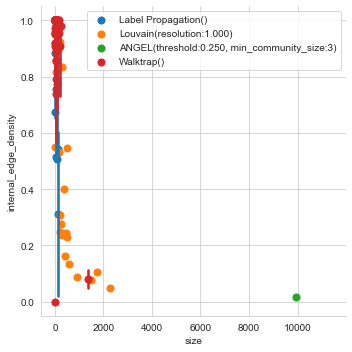

In [111]:
viz.plot_com_properties_relation([lp_coms, louv_coms, DA_coms, wt_coms], evaluation.size, evaluation.internal_edge_density)

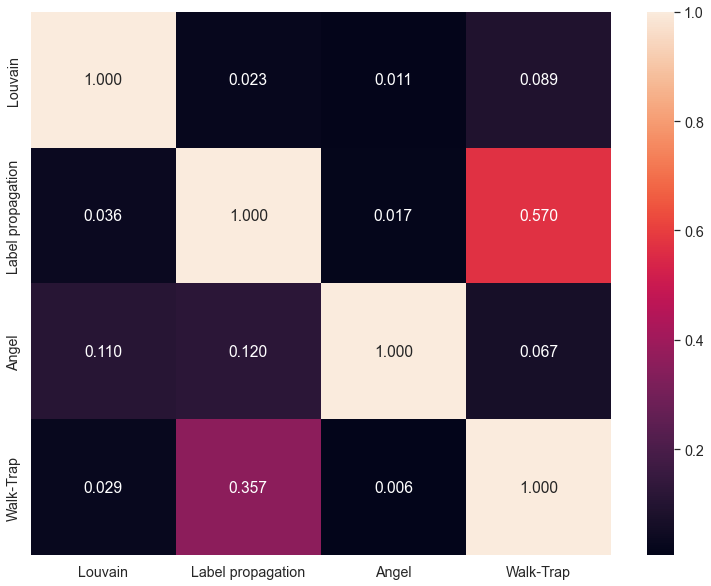

In [365]:
# Printing heatmap matrix with labels

cdNF1 = {}
cdNF1['Louvain'] = louv_coms
cdNF1['Label propagation'] = lp_coms
cdNF1['Angel'] = DA_coms
cdNF1['Walk-Trap'] = wt_coms

rows = []
for key1, value1 in cdNF1.items():
    row = []
    row.append(key1)
    for key2, value2 in cdNF1.items():
        if key1 == key2:
            row.append(1.0)
        else:
            row.append(ComparisonNF1(value1, value2).score)
    rows.append(row)

df = pd.DataFrame(rows, columns=[""]+list(cdNF1.keys()))
df.set_index('', inplace=True)


fig, ax = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax = sns.heatmap(df, annot=True, fmt='.3f')
fig.savefig("plots/heatmap-f1-comparison.png")



In [542]:
df

,Louvain,Label propagation,Angel,Walk-Trap
,,,,
Louvain,1.000000,0.022742,0.011111,0.089148
Label propagation,0.036146,1.000000,0.016503,0.569563
Angel,0.109714,0.119630,1.000000,0.067213
Walk-Trap,0.028550,0.356517,0.006003,1.000000


In [366]:
#using normalized f1 score:

def ComparisonONMI (coms1, coms2):
    ONMI= evaluation.overlapping_normalized_mutual_information_LFK(coms1, coms2)
    return ONMI

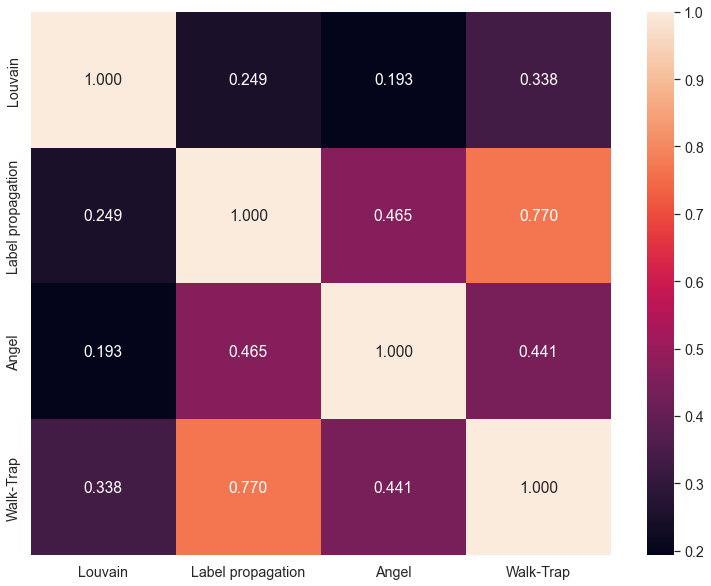

In [367]:
# Printing heatmap matrix with labels

cdONMI = {}
cdONMI['Louvain'] = louv_coms
cdONMI['Label propagation'] = lp_coms
cdONMI['Angel'] = DA_coms
cdONMI['Walk-Trap'] = wt_coms

rows = []
for key1, value1 in cdONMI.items():
    row = []
    row.append(key1)
    for key2, value2 in cdONMI.items():
        if key1 == key2:
            row.append(1.0)
        else:
            row.append(ComparisonONMI(value1, value2).score)
    rows.append(row)

df1 = pd.DataFrame(rows, columns=[""]+list(cdONMI.keys()))
df1.set_index('', inplace=True)


fig1, ax1 = plt.subplots(figsize=(13,10))

sns.set(font_scale=1.3)
ax1 = sns.heatmap(df1, annot=True, fmt='.3f')


In [368]:
fig1.savefig("plots/heatmap-ONMI-comparison.png")